In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from xgboost import XGBClassifier
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, mean_squared_error

In [2]:
df = pd.read_csv("beers.csv", index_col=0)
df1 = pd.read_csv("breweries.csv", index_col=0)

In [3]:
#renaming the 1st column from name to brewery_name
df1.rename(columns={ df1.columns[0]: "brewery_name" }, inplace = True)
#join the tables
df = pd.merge(df, df1, how='left', left_on = 'brewery_id', right_index = True)

In [4]:
df['style'] = df['style'].astype('string')

In [6]:
df = df[np.abs(df.ibu-df.ibu.mean()) <= (3*df.ibu.std())]
df = df[np.abs(df.abv-df.abv.mean()) <= (3*df.abv.std())]
df = df[np.abs(df.ounces-df.ounces.mean()) <= (3*df.ounces.std())]


In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df[['abv', 'ibu', 'ounces']] = scaler.fit_transform(df[['abv', 'ibu', 'ounces']])

In [8]:
df

,abv,ibu,id,name,style,brewery_id,ounces,brewery_name,city,state
14,0.465753,0.482759,1979,Bitter Bitch,American Pale Ale (APA),177,0.333333,18th Street Brewery,Gary,IN
21,0.986301,0.758621,1036,Lower De Boom,American Barleywine,368,0.000000,21st Amendment Brewery,San Francisco,CA
22,0.712329,0.353448,1024,Fireside Chat,Winter Warmer,368,0.333333,21st Amendment Brewery,San Francisco,CA
24,0.232877,0.327586,876,Bitter American,American Pale Ale (APA),368,0.333333,21st Amendment Brewery,San Francisco,CA
25,0.301370,0.112069,802,Hell or High Watermelon Wheat (2009),Fruit / Vegetable Beer,368,0.333333,21st Amendment Brewery,San Francisco,CA
...,...,...,...,...,...,...,...,...,...,...
2398,0.684932,0.224138,1513,Lights Out Vanilla Cream Extra Stout,American Double / Imperial IPA,199,0.333333,Worthy Brewing Company,Bend,OR
2399,0.575342,0.560345,1512,Worthy IPA (2013),American IPA,199,0.333333,Worthy Brewing Company,Bend,OR
2400,0.452055,0.396552,1511,Worthy Pale,American Pale Ale (APA),199,0.333333,Worthy Brewing Company,Bend,OR
2405,0.547945,0.353448,928,Belgorado,Belgian IPA,424,0.333333,Wynkoop Brewing Company,Denver,CO


In [9]:
df.loc[(df["style"].str.contains("ipa", na=False, case=False)), "isipa"] = '1'
df=df.fillna("0")
df['isipa']=df['isipa'].astype(int)

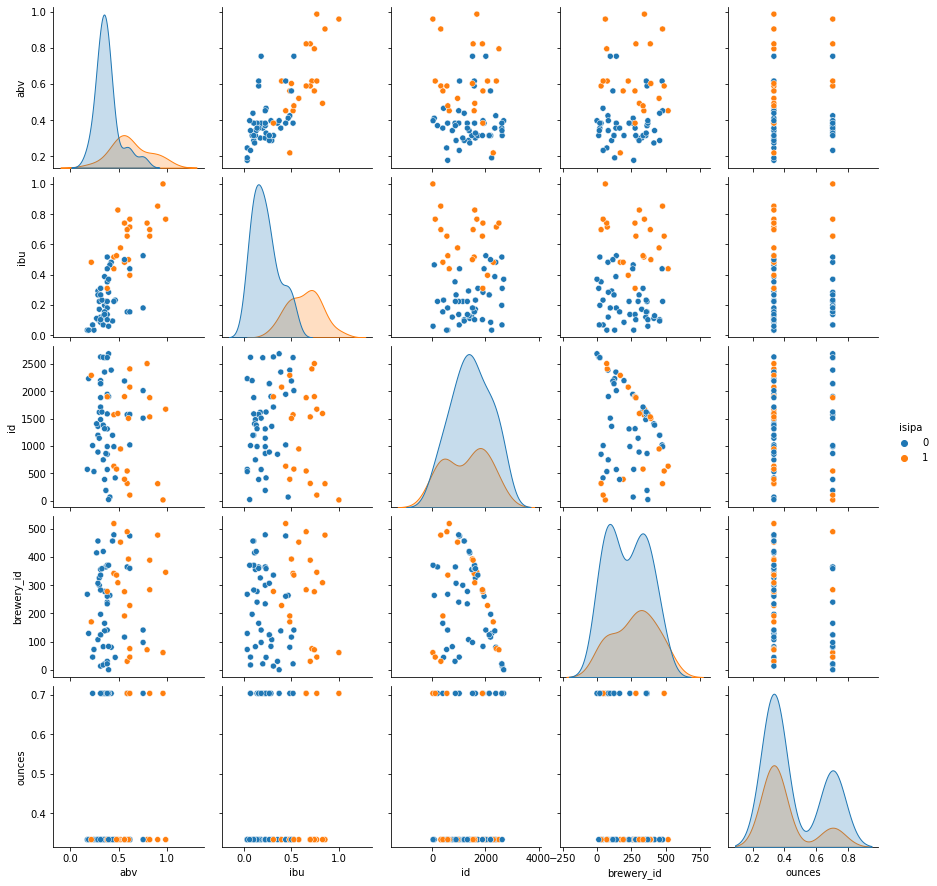

In [10]:
df_sample = df.sample(frac=0.05)
pplot = sns.pairplot(df_sample, hue="isipa")

In [11]:
X = df[['abv','ibu','ounces']] # Features
y = df['isipa']# Target

In [12]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=1)

In [13]:
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    silent=True, nthread=1)

In [14]:
model = XGBClassifier()
param_grid = {
        'min_child_weight': [1,5, 10],
        'gamma': [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.1, 0.2, 0.3, 0.6, 0.8, 1.0],
        'colsample_bytree': [0.1, 0.2, 0.3, 0.6, 0.8, 1.0],
        'max_depth': [1,2,5,8,10]
        }

In [15]:
model_roc_auc= RandomizedSearchCV(estimator=model, 
                                  param_distributions=param_grid,
                                  n_iter=300,
                                  scoring='roc_auc', cv=3)

In [16]:
model_roc_auc.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_iter=300,
                   param_distributions={'colsample_bytree': [0.1, 0.2, 0.3, 0.6,
                                                             0.8, 1.0],
                                        'gamma': [0.1, 0.2, 0.3, 0.5, 1, 1.5, 2,
                                                  5],
                                        'max_depth': [1, 2, 5, 8, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'subsample': [0.1, 0.2, 0.3, 0.6, 0.8,
                                                      1.0]},
                   scoring='roc_auc')

In [17]:
model_roc_auc.best_params_

{'subsample': 0.8,
 'min_child_weight': 1,
 'max_depth': 1,
 'gamma': 0.3,
 'colsample_bytree': 0.8}

In [18]:

model_roc_auc = XGBClassifier(**model_roc_auc.best_params_)

model_roc_auc = model_roc_auc.fit(X_train,y_train)

In [19]:
y_pred = model_roc_auc.predict(X_test)

In [20]:
y_pred_train = model_roc_auc.predict(X_train)
accuracy_train = float(np.sum(y_pred_train==y_train))/y_train.shape[0]
print('accuracy: %f' %(accuracy_train))

accuracy: 0.898290


In [21]:
#Confususion matrix for the test
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
print(cnf_matrix)


[[187  19]
 [ 11  61]]


In [22]:
#accuracy
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#mean squared error
rms = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMS: ',rms)

Accuracy: 0.8920863309352518
RMS:  0.3285021599088021
